In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import numpy as np
import pandas as pd
import scipy.sparse as ssp
from functools import lru_cache
from tqdm import tqdm, trange

import xgboost as xgb 
import catboost as cat 
from catboost import CatBoostRanker, Pool
from sklearn.model_selection import GroupKFold
import time
import matplotlib.pyplot as plt

In [2]:
merged_candidates_feature_test_path = '/root/autodl-tmp/xiaolong/WorkSpace/Amazon-KDDCUP-23/XGBoost/candidates/merged_candidates_test_feature.parquet'

In [3]:
@lru_cache(maxsize=1)
def read_merged_candidates_feature_test():
    return pd.read_parquet(merged_candidates_feature_test_path, engine='pyarrow')

In [5]:
test_candidates = read_merged_candidates_feature_test()

In [ ]:
test_candidates.query('sess_id==50505').sort_values(by=['sasrec_scores_3'], ascending=False)[:25]

,sess_id,sess_locale,product,product_freq,sess_avg_price,product_price,sasrec_scores_2,normalized_sasrec_scores_2,narm_scores,normalized_narm_scores,...,normalized_roberta_scores,gru4rec_scores_2,normalized_gru4rec_scores_2,title_BM25_scores,desc_BM25_scores,cos_bert_scores,bert_scores,normalized_bert_scores,sasrec_text_scores,normalized_sasrec_text_scores
10311597,50505,DE,B08X4LQ154,124.0,19.99,13.990000,18.186922,0.214530,15.435417,0.075537,...,0.025774,18.888275,0.055035,763.782471,788.837769,0.969308,393.403412,0.051211,19.141308,0.264026
10311598,50505,DE,B08X4MBB7V,26.0,19.99,18.990000,17.737623,0.136886,15.190865,0.059150,...,0.025700,19.719635,0.126384,763.782471,792.852844,0.968479,393.316315,0.046939,17.945301,0.079841
10311585,50505,DE,B08VZCB5R2,35.0,19.99,18.900000,17.672295,0.128229,14.813783,0.040569,...,0.000817,18.401764,0.033833,169.929413,238.340134,0.941674,385.542969,0.000020,17.575888,0.055182
10311599,50505,DE,B08X4N9FZ6,14.0,19.99,24.990000,16.119509,0.027141,13.553603,0.011505,...,0.025700,17.762880,0.017860,755.730347,798.544189,0.966210,392.408905,0.018943,16.982876,0.030497
10311551,50505,DE,B07MM58SQ3,13.0,19.99,20.990000,15.499866,0.014605,12.765821,0.005233,...,0.000803,16.807346,0.006869,281.176300,84.427994,0.952608,389.233368,0.000791,16.535927,0.019505
10311642,50505,DE,B09SHZFRLM,46.0,19.99,22.900000,16.365904,0.034724,15.103813,0.054219,...,0.008834,18.277122,0.029869,572.495483,391.895386,0.964156,391.155151,0.005407,17.172886,0.036878
10311672,50505,DE,B0BHS7BT4X,20.0,19.99,15.990000,15.948169,0.022867,14.314607,0.024626,...,0.004692,18.845341,0.052722,552.915039,216.992996,0.962507,392.363556,0.018103,16.951687,0.029560
10311664,50505,DE,B0B4DXCCH3,7.0,19.99,49.990002,16.341949,0.033902,13.743576,0.013912,...,0.025507,17.091818,0.009129,755.730347,783.349182,0.965843,392.238220,0.015971,16.536125,0.019509
10311596,50505,DE,B08X4L7GNM,7.0,19.99,21.990000,15.235008,0.011207,13.295126,0.008885,...,0.025700,17.123560,0.009424,755.730347,793.235596,0.967034,392.764679,0.027037,15.957078,0.010933
10311666,50505,DE,B0BFWN51M8,50.0,19.99,24.990000,16.156065,0.028151,14.518084,0.030183,...,0.001430,17.662693,0.016157,508.506165,153.338776,0.953169,387.233795,0.000107,17.067205,0.033180


In [6]:
FEATURES = ['product_freq', 'product_price',
             'sasrec_scores_2', 'normalized_sasrec_scores_2', 
             'sasrec_scores_3', 'normalized_sasrec_scores_3', 
             'gru4rec_scores', 'normalized_gru4rec_scores',
             'gru4rec_scores_2', 'normalized_gru4rec_scores_2',
             'roberta_scores', 'normalized_roberta_scores',
             'bert_scores', 'normalized_bert_scores',
             'co_graph_counts_0', 'normalized_co_graph_counts_0',
             'co_graph_counts_1', 'normalized_co_graph_counts_1',
             'co_graph_counts_2', 'normalized_co_graph_counts_2',
             'title_BM25_scores', 'desc_BM25_scores',
             'all_items_co_graph_count_0', 'normalized_all_items_co_graph_count_0',
             'all_items_co_graph_count_1', 'normalized_all_items_co_graph_count_1',
             'all_items_co_graph_count_2', 'normalized_all_items_co_graph_count_2',
             'seqmlp_scores', 'normalized_seqmlp_scores',
             'narm_scores', 'normalized_narm_scores',
             'sasrec_feat_scores', 'normalized_sasrec_feat_scores',
             'sasrec_text_scores', 'normalized_sasrec_text_scores',
             'sess_avg_price', 'sess_locale']
FEATURES.sort()
FOLDS = 5
TOPK = 100
ckpt_list = []
for i in range(FOLDS):
    ckpt_list.append(f'./cat_ckpt/CAT_2023_05_28_16_06_41_fold{i}.cat')

In [11]:
FEATURES, len(FEATURES)

(['all_items_co_graph_count_0',
  'all_items_co_graph_count_1',
  'all_items_co_graph_count_2',
  'bert_scores',
  'co_graph_counts_0',
  'co_graph_counts_1',
  'co_graph_counts_2',
  'desc_BM25_scores',
  'gru4rec_scores',
  'gru4rec_scores_2',
  'narm_scores',
  'normalized_all_items_co_graph_count_0',
  'normalized_all_items_co_graph_count_1',
  'normalized_all_items_co_graph_count_2',
  'normalized_bert_scores',
  'normalized_co_graph_counts_0',
  'normalized_co_graph_counts_1',
  'normalized_co_graph_counts_2',
  'normalized_gru4rec_scores',
  'normalized_gru4rec_scores_2',
  'normalized_narm_scores',
  'normalized_roberta_scores',
  'normalized_sasrec_feat_scores',
  'normalized_sasrec_scores_2',
  'normalized_sasrec_scores_3',
  'normalized_sasrec_text_scores',
  'normalized_seqmlp_scores',
  'product_freq',
  'product_price',
  'roberta_scores',
  'sasrec_feat_scores',
  'sasrec_scores_2',
  'sasrec_scores_3',
  'sasrec_text_scores',
  'seqmlp_scores',
  'sess_avg_price',
  'se

In [14]:
preds = np.zeros(len(test_candidates))

In [15]:
for fold in range(FOLDS):
    model = CatBoostRanker()
    model.load_model(ckpt_list[fold])
    dtest = Pool(
        cat_features=['sess_locale'],
        data = test_candidates[FEATURES],
        group_id = test_candidates['sess_id']
    )
    # dtest = xgb.DMatrix(data=test_candidates[FEATURES])
    preds += model.predict(dtest) / (FOLDS * 2)

In [16]:
test_candidates['sess_locale'] = test_candidates['sess_locale'].astype('category')

In [17]:
xgb_ckpt_list = []
for i in range(FOLDS):
    xgb_ckpt_list.append(f'./ckpt/XGB_2023_05_27_22_07_16_fold{i}.json')

In [18]:
for fold in range(FOLDS):
    print(fold)
    model = xgb.Booster()
    model.load_model(xgb_ckpt_list[fold])
    model.set_param({'predictor': 'gpu_predictor'})
    dtest = xgb.DMatrix(data=test_candidates[FEATURES], enable_categorical=True)
    # dtest = xgb.DMatrix(data=test_candidates[FEATURES])
    pred_ = model.predict(dtest)
    preds += pred_ / (FOLDS * 2)

0
1
2
3
4


In [19]:
predictions = test_candidates[['sess_id','sess_locale', 'product']].copy()
predictions['pred'] = preds
predictions = predictions.sort_values(['sess_id','pred'], ascending=[True, False]).reset_index(drop=True)
predictions['n'] = predictions.groupby('sess_id')['product'].cumcount().astype('int32')
predictions = predictions.loc[predictions['n'] < TOPK]

In [20]:
sub = pd.DataFrame({})
sub['next_item_prediction'] = predictions.groupby('sess_id')['product'].apply(list)
sub['locale'] = predictions.groupby('sess_id')['sess_locale'].apply(lambda x : x.iloc[0])
sub.reset_index(drop=True, inplace=True)

In [21]:
sub['next_item_prediction'].apply(len).describe()

count    316972.0
mean        100.0
std           0.0
min         100.0
25%         100.0
50%         100.0
75%         100.0
max         100.0
Name: next_item_prediction, dtype: float64

In [22]:
sub.to_parquet('../predictions/XGBoost/catboost_and_xgboost_05_28_17_40.parquet', engine='pyarrow')

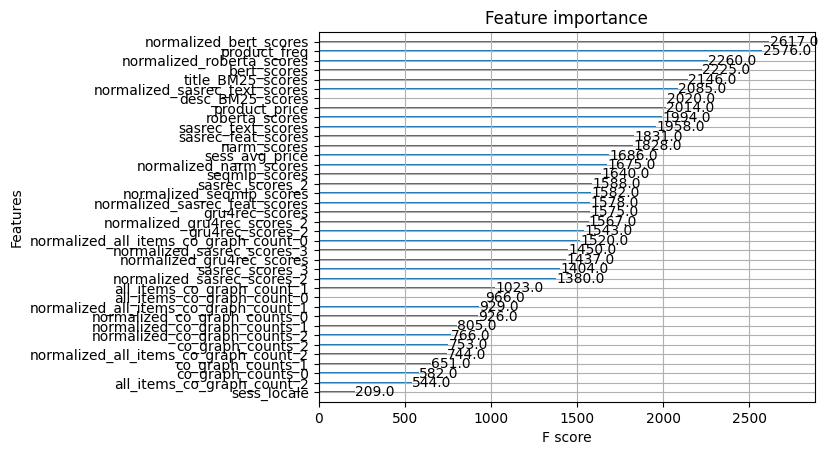

In [38]:
# xgb.plot_importance(model)
# plt.show()

In [23]:
test_candidates

,sess_id,sess_locale,product,product_freq,sess_avg_price,product_price,sasrec_scores_2,normalized_sasrec_scores_2,narm_scores,normalized_narm_scores,...,normalized_roberta_scores,gru4rec_scores_2,normalized_gru4rec_scores_2,title_BM25_scores,desc_BM25_scores,cos_bert_scores,bert_scores,normalized_bert_scores,sasrec_text_scores,normalized_sasrec_text_scores
0,0,DE,B00NM3GIQC,5.0,67.527199,72.989998,10.414718,9.450233e-06,10.117798,2.279188e-05,...,8.647214e-04,9.898176,1.875848e-05,95.106377,66.655685,0.943744,387.168518,1.267623e-05,11.139684,1.291134e-04
1,0,DE,B00R6ADUVS,14.0,67.527199,7.990000,0.110955,3.166471e-10,-0.497686,5.591575e-10,...,4.980903e-07,-1.198245,2.845006e-10,2.454583,27.670429,0.923832,378.738251,2.765424e-09,3.150757,4.379499e-08
2,0,DE,B00R6ADV0I,38.0,67.527199,4.950000,-1.027181,1.014586e-10,0.092900,1.009305e-09,...,1.194164e-06,-1.130973,3.042980e-10,0.000000,47.186230,0.930843,380.994507,2.640275e-08,0.466538,2.990081e-09
3,0,DE,B00ZQW91DE,57.0,67.527199,49.990002,12.473682,7.406952e-05,11.916263,1.376713e-04,...,1.338980e-03,12.712816,3.130258e-04,54.398838,64.691559,0.947253,387.712708,2.184332e-05,12.239294,3.877270e-04
4,0,DE,B0186L0UIG,206.0,67.527199,10.000000,2.030347,2.158523e-09,6.575135,6.595095e-07,...,5.699628e-05,4.938198,1.315547e-07,33.074673,0.000000,0.942447,384.940918,1.366324e-06,9.116092,1.706619e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65960104,316971,UK,B0B7NVV55M,3.0,19.459999,35.990002,1.400551,1.092418e-06,7.152122,1.556619e-05,...,5.579707e-03,8.931839,1.377056e-05,227.406769,172.038223,0.980418,445.642456,8.509892e-03,7.810712,4.854852e-06
65960105,316971,UK,B0B7NWR653,12.0,19.459999,9.990000,8.983312,2.145555e-03,10.446548,4.196942e-04,...,1.376993e-02,13.131494,9.179911e-04,242.227097,165.010849,0.982217,446.558838,2.127656e-02,15.575103,1.143426e-02
65960106,316971,UK,B0B7NXBM6P,9.0,19.459999,9.950000,3.749935,1.144756e-05,6.312058,6.719659e-06,...,6.110368e-03,6.900970,1.806992e-06,235.617920,177.015549,0.981151,445.983337,1.196646e-02,7.273209,2.836230e-06
65960107,316971,UK,B0BHW1D5VP,23.0,19.459999,26.990000,6.356702,1.551735e-04,10.685316,5.328793e-04,...,1.271922e-03,12.784711,6.489821e-04,106.043022,31.416847,0.971422,440.133820,3.447867e-05,12.020029,3.267828e-04


In [24]:
preds

array([ -1.48105124,  -6.50533031,  -6.7799978 , ...,  -1.04766597,
        -0.44442769, -11.31408504])